In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm  import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils
import torch.backends.cudnn as cudnn

from pytvision.transforms import transforms as mtrans
from pytvision import visualization as view

sys.path.append('../')
from torchlib.datasets.factory  import FactoryDataset 
from torchlib.datasets import Dataset

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
pathname = '~/.datasets'
pathname = os.path.expanduser( pathname )
name_dataset=FactoryDataset.affect

print(pathname)
print(name_dataset)

/home/fernandez/.datasets
affectnet


In [3]:
def visualizatedataset( data, num=25, imsize=(64,64,3), padding=1 ):    
    """
    Visualization data set
        @data: data loader 
        @num: number of images show
    """
    
    databatch = torch.zeros( [num, imsize[2], imsize[0], imsize[1]], dtype=torch.float32 )
    for i in range(num): 
        idx = i # np.random.randint( len(data) )
        databatch[i,...] = data[idx]['image']   
        
    grid = utils.make_grid( databatch , nrow= int(np.sqrt(num)), normalize=True, padding=padding )       
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [4]:
dataloader = Dataset(
    data=FactoryDataset.factory(
        pathname=pathname, 
        name=name_dataset, 
        subset=FactoryDataset.training, 
        download=True ),
    num_channels=3,
    transform=transforms.Compose([
        mtrans.ToResize( (48, 48), resize_mode='squash', padding_mode=cv2.BORDER_REPLICATE ),
        #mtrans.ToResize( (38, 38), resize_mode='squash', padding_mode=cv2.BORDER_REPLICATE ),
        #mtrans.ToPad( 5 , 5, padding_mode=cv2.BORDER_REPLICATE ) ,        
        #mtrans.ToResize( (60, 60), resize_mode='squash', padding_mode=cv2.BORDER_REPLICATE ),
        #mtrans.CenterCrop( (48, 48), padding_mode=cv2.BORDER_REPLICATE  ) , 
        mtrans.ToTensor(),
        mtrans.ToNormalization(),
        ])
    )

print(len( dataloader.data.classes ))
print( dataloader.data.class_to_idx )
# print( dataloader.data.classes )
# print(len(dataloader))
# print( dataloader.data.samples )

8
{'Neutral - NE': 0, 'Happiness - HA': 1, 'Surprise - SU': 2, 'Sadness - SA': 3, 'Anger - AN': 4, 'Disgust - DI': 5, 'Fear - FR': 6, 'Contempt - CO': 7}


['Neutral - NE', 'Happiness - HA', 'Surprise - SU', 'Sadness - SA', 'Anger - AN', 'Disgust - DI', 'Fear - FR', 'Contempt - CO']
101


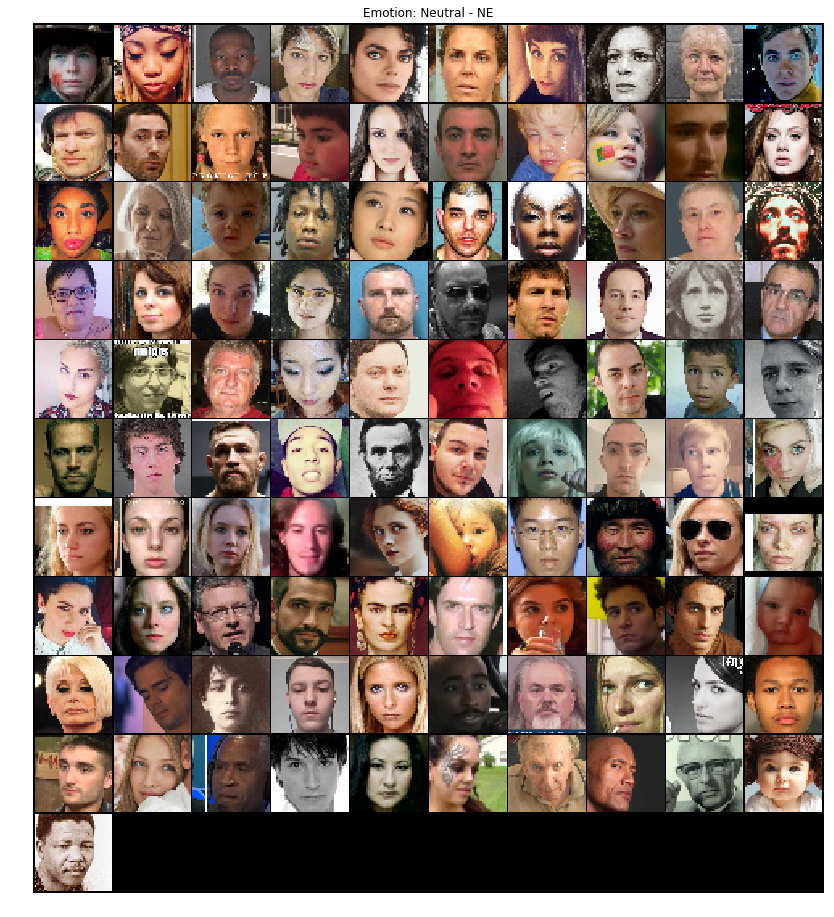

In [5]:
num=100
classes_select = 0
dataloader_select = []
k=0
labels = dataloader.labels
imsize = 48

for i in range( len(dataloader) ):
    if labels[i] != classes_select: 
        continue        
    dataloader_select.append(dataloader[i]); k+=1
    if k > num: break;

n = len(dataloader_select)

print(dataloader.data.classes)
print(n)


plt.figure( figsize=(16,16))
visualizatedataset(dataloader_select, num=n, imsize=(imsize,imsize,3) )
plt.title('Emotion: {}'.format( dataloader.data.classes[ classes_select ] ) )
plt.axis('off')
plt.ioff()
plt.show() 

In [ ]:
plt.figure( figsize=(16,16))
view.visualizatedataset(dataloader, num=600, imsize=(imsize,imsize,3) )
plt.axis('off')
plt.ioff()
plt.show() 

287651


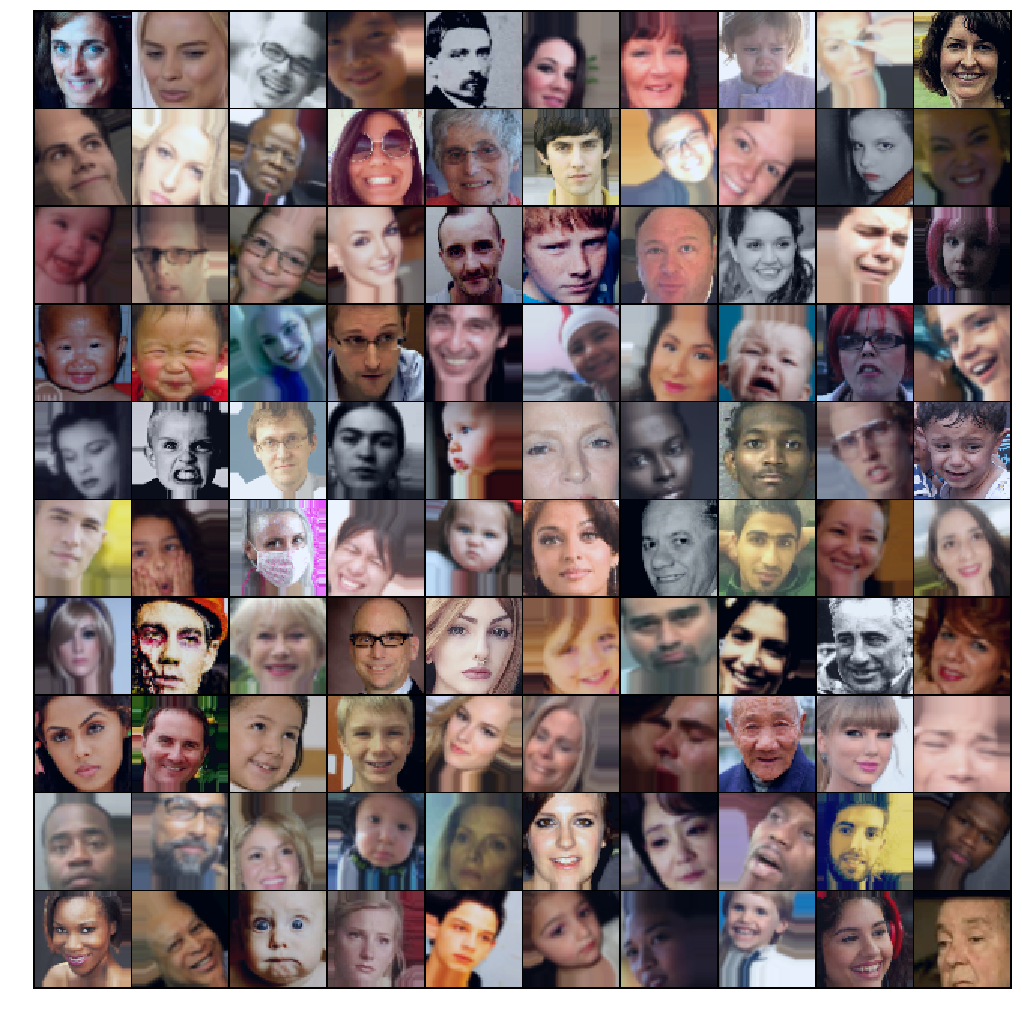

In [6]:

size_input = 64

train_transform = transforms.Compose(
    [ 
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(size_input, padding=4), 
    ])

# transformations 
normalize = mtrans.ToMeanNormalization(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )

transforms_aug = transforms.Compose([
    
    #mtrans.ToResize( (size_input, size_input), resize_mode='square', padding_mode=cv2.BORDER_REPLICATE ) ,
    mtrans.ToResize( (size_input+5, size_input+5), resize_mode='square' ) ,
    mtrans.RandomCrop( (size_input, size_input), limit=2, padding_mode=cv2.BORDER_REPLICATE  ) , 
    mtrans.RandomScale( factor=0.2, padding_mode=cv2.BORDER_REPLICATE ), 
    mtrans.ToRandomTransform( mtrans.RandomGeometricalTransform( angle=30, translation=0.2, warp=0.02, padding_mode=cv2.BORDER_REPLICATE ), prob=0.5 ),
    mtrans.ToRandomTransform( mtrans.VFlip(), prob=0.5 ),
    
    #------------------------------------------------------------------
           
    #mtrans.ToRandomTransform( mtrans.RandomRGBPermutation(), prob=0.30 ),
    mtrans.ToRandomTransform( mtrans.RandomBrightness( factor=0.15 ), prob=0.50 ),
    mtrans.ToRandomTransform( mtrans.RandomContrast( factor=0.15 ), prob=0.50 ),
    mtrans.ToRandomTransform( mtrans.RandomGamma( factor=0.15 ), prob=0.50 ),
    mtrans.ToRandomTransform( mtrans.RandomHueSaturation( hue_shift_limit=(-5, 5), sat_shift_limit=(-11, 11), val_shift_limit=(-11, 11) ), prob=0.30 ),
    #mtrans.ToRandomTransform( mtrans.ToGrayscale(), prob=0.30 ),
    
    
    #mtrans.RandomRGBPermutation(),
    #mtrans.ToRandomChoiceTransform( [
    #    mtrans.RandomBrightness( factor=0.15 ), 
    #    mtrans.RandomContrast( factor=0.15 ),
    #    #mtrans.RandomSaturation( factor=0.15 ),
    #    mtrans.RandomHueSaturation( hue_shift_limit=(-5, 5), sat_shift_limit=(-11, 11), val_shift_limit=(-11, 11) ),
    #    mtrans.RandomGamma( factor=0.30  ),        
    #    mtrans.ToRandomTransform(mtrans.ToGrayscale(), prob=0.15 ),
    #    ]),    
    
    #mtrans.ToRandomTransform(mtrans.ToGaussianBlur( sigma=0.00001), prob=0.50 ),    
    
    #------------------------------------------------------------------
    mtrans.ToTensor(),
    normalize,
    ]) 


transforms_det = transforms.Compose([
    #mtrans.ToResize( (size_input, size_input), resize_mode='crop' ) ,
    mtrans.ToResize( (size_input, size_input), resize_mode='square', padding_mode=cv2.BORDER_REFLECT_101 ) ,
    mtrans.ToTensor(),
    normalize,
    ])

dataloader = Dataset(
    data=FactoryDataset.factory(
        pathname=pathname, 
        name=name_dataset, 
        subset=FactoryDataset.training, 
        #transform=train_transform, 
        download=False ),
    num_channels=3,
    transform=transforms_aug
    )

print( len(dataloader) )
plt.figure( figsize=(18,18) )
view.visualizatedataset(dataloader, num=100, imsize=(size_input,size_input,3), padding=1 )
plt.axis('off')
plt.ioff()
plt.show()

